<a href="https://colab.research.google.com/github/shreekar2005/Cheminformatics_DC/blob/main/Cheminformatics_DC_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import cupy as cp  # GPU acceleration
import cudf  # GPU dataframe
from cuml.preprocessing import StandardScaler  # GPU scaler
from cuml.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier
from cuml.svm import SVC
from cuml.naive_bayes import GaussianNB
from cuml.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier  # GPU-accelerated Gradient Boosting
from sklearn.tree import DecisionTreeClassifier  # No GPU support in RAPIDS
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
import rmm
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



# Loading Dataset

In [2]:
# Initialize GPU memory pool
rmm.reinitialize(pool_allocator=True, initial_pool_size=4*1024*1024*1024)  # 4GB Pool

# Load data into cudf (GPU DataFrame)
url1 = 'https://raw.githubusercontent.com/shreekar2005/Cheminformatics_DC/refs/heads/main/DATASET_sorted/TRAIN_dense/tox21_dense_train.csv'
url2 = 'https://raw.githubusercontent.com/shreekar2005/Cheminformatics_DC/refs/heads/main/DATASET_sorted/TRAIN_dense/tox21_labels_train.csv'
url3 = 'https://raw.githubusercontent.com/shreekar2005/Cheminformatics_DC/refs/heads/main/DATASET_sorted/TEST_dense/tox21_dense_test.csv'
url4 = 'https://raw.githubusercontent.com/shreekar2005/Cheminformatics_DC/refs/heads/main/DATASET_sorted/TEST_dense/tox21_labels_test.csv'

train_features = cudf.read_csv(url1)
train_labels = cudf.read_csv(url2)
test_features = cudf.read_csv(url3)
test_labels = cudf.read_csv(url4)

target_labels = ['NR.AhR', 'NR.AR', 'NR.AR.LBD', 'NR.Aromatase', 'NR.ER', 'NR.ER.LBD',
                 'NR.PPAR.gamma', 'SR.ARE', 'SR.ATAD5', 'SR.HSE', 'SR.MMP', 'SR.p53']

dense_features = train_features.select_dtypes(include=['float64', 'int64']).columns.tolist()
X_train = train_features[dense_features].to_cupy()
X_test = test_features[dense_features].to_cupy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_labels[target_labels] = train_labels[target_labels].fillna(0).clip(0, 1)
test_labels[target_labels] = test_labels[target_labels].fillna(0).clip(0, 1)

y_train = train_labels[target_labels].to_cupy()
y_test = test_labels[target_labels].to_cupy()

# Convert CuPy arrays to NumPy for sklearn compatibility
y_train = cp.asnumpy(y_train)
y_test = cp.asnumpy(y_test)
X_train = cp.asnumpy(X_train)
X_test = cp.asnumpy(X_test)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (12060, 801)
Testing data shape: (647, 801)
Training labels shape: (12060, 12)
Testing labels shape: (647, 12)


# Applying classifiers

## Defining Classifiers

In [3]:
# Define Classifier Classes
class LogisticRegressionModel:
    def __init__(self):
        self.model = MultiOutputClassifier(LogisticRegression(max_iter=5000))

class RandomForestModel:
    def __init__(self):
        self.model = MultiOutputClassifier(RandomForestClassifier(n_estimators=50))

class GradientBoostingModel:
    def __init__(self):
        self.model = MultiOutputClassifier(XGBClassifier(n_estimators=100, device='cuda', eval_metric='logloss'))


class NaiveBayesModel:
    def __init__(self):
        self.model = MultiOutputClassifier(GaussianNB())

class KNNModel:
    def __init__(self):
        self.model = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=5))

class DecisionTreeModel:
    def __init__(self):
        self.model = MultiOutputClassifier(DecisionTreeClassifier(max_depth=None))

class SVMModel:
    def __init__(self):
        self.model = MultiOutputClassifier(SVC(kernel='linear'))

## Defining functions to plot graph and train and find accuricies

In [4]:
def plot_confusion_matrices(name, y_true, y_pred):
    cm_matrices = multilabel_confusion_matrix(y_true, y_pred)

    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))  # 12 target labels (3x4 grid)
    fig.suptitle(f"Confusion Matrices for {name}", fontsize=16)

    for i, (cm, label) in enumerate(zip(cm_matrices, target_labels)):
        ax = axes[i // 4, i % 4]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], ax=ax)
        ax.set_title(label)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [5]:
# Training Function
def train_classifier(name, classifier, X_train, y_train, X_test, y_test, batch_size=1000):
    print(f"\nTraining {name}...")
    classifier.fit(X_train, y_train)
    print(f"{name} training completed.")

    y_train_pred = classifier.predict(X_train)
    y_test_pred = np.vstack([classifier.predict(X_test[i:i+batch_size]) for i in range(0, X_test.shape[0], batch_size)])

    print(f"\nAccuracy for {name}:")
    for i, label in enumerate(target_labels):
        train_acc = accuracy_score(y_train[:, i], y_train_pred[:, i])
        test_acc = accuracy_score(y_test[:, i], y_test_pred[:, i])
        print(f"{label}: Train Accuracy = {train_acc:.4f}, Test Accuracy = {test_acc:.4f}")

    plot_confusion_matrices(name, y_test, y_test_pred)

In [6]:
# Initialize and Train Classifiers
logistic_regression = LogisticRegressionModel().model
random_forest = RandomForestModel().model
gradient_boosting = GradientBoostingModel().model
naive_bayes = NaiveBayesModel().model
knn = KNNModel().model
decision_tree = DecisionTreeModel().model
svm = SVMModel().model

[2025-03-30 12:02:19.256] [CUML] [warning] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.


## Training and Testing models


Training Logistic Regression...
Logistic Regression training completed.

Accuracy for Logistic Regression:
NR.AhR: Train Accuracy = 0.9362, Test Accuracy = 0.8903
NR.AR: Train Accuracy = 0.9777, Test Accuracy = 0.9768
NR.AR.LBD: Train Accuracy = 0.9835, Test Accuracy = 0.9830
NR.Aromatase: Train Accuracy = 0.9743, Test Accuracy = 0.9351
NR.ER: Train Accuracy = 0.9328, Test Accuracy = 0.9073
NR.ER.LBD: Train Accuracy = 0.9734, Test Accuracy = 0.9583
NR.PPAR.gamma: Train Accuracy = 0.9842, Test Accuracy = 0.9382
SR.ARE: Train Accuracy = 0.9153, Test Accuracy = 0.8454
SR.ATAD5: Train Accuracy = 0.9749, Test Accuracy = 0.9428
SR.HSE: Train Accuracy = 0.9713, Test Accuracy = 0.9567
SR.MMP: Train Accuracy = 0.9230, Test Accuracy = 0.8903
SR.p53: Train Accuracy = 0.9611, Test Accuracy = 0.9289


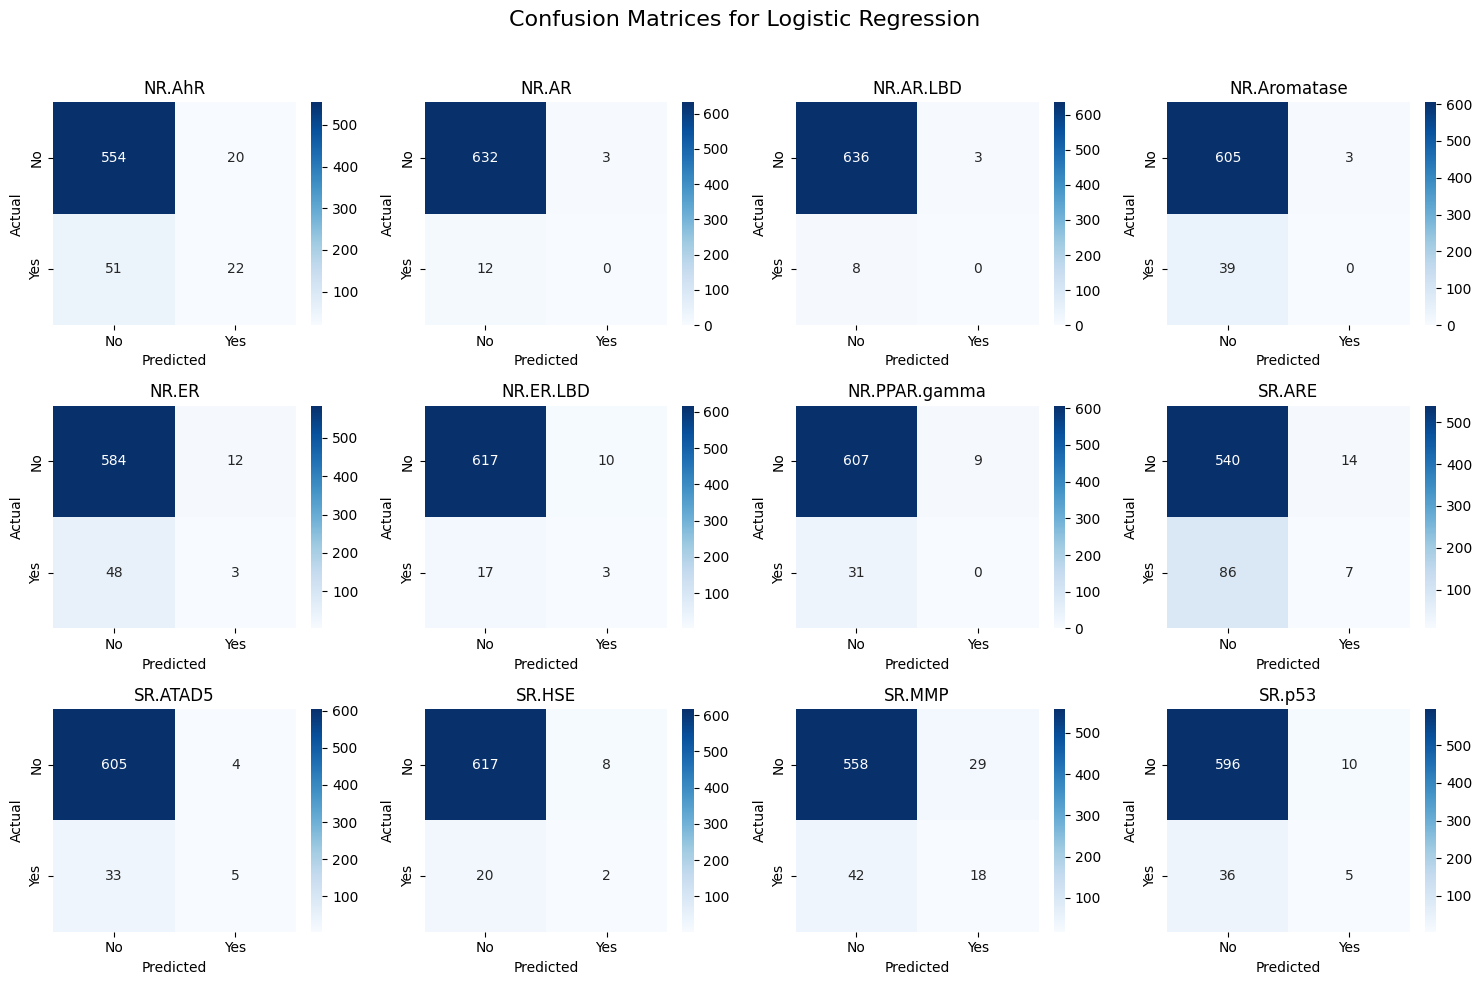

In [7]:
train_classifier("Logistic Regression", logistic_regression, X_train, y_train, X_test, y_test)


Training Random Forest...
Random Forest training completed.

Accuracy for Random Forest:
NR.AhR: Train Accuracy = 0.9886, Test Accuracy = 0.8918
NR.AR: Train Accuracy = 0.9920, Test Accuracy = 0.9830
NR.AR.LBD: Train Accuracy = 0.9948, Test Accuracy = 0.9830
NR.Aromatase: Train Accuracy = 0.9891, Test Accuracy = 0.9397
NR.ER: Train Accuracy = 0.9739, Test Accuracy = 0.9274
NR.ER.LBD: Train Accuracy = 0.9928, Test Accuracy = 0.9706
NR.PPAR.gamma: Train Accuracy = 0.9936, Test Accuracy = 0.9521
SR.ARE: Train Accuracy = 0.9643, Test Accuracy = 0.8516
SR.ATAD5: Train Accuracy = 0.9934, Test Accuracy = 0.9413
SR.HSE: Train Accuracy = 0.9833, Test Accuracy = 0.9645
SR.MMP: Train Accuracy = 0.9813, Test Accuracy = 0.9026
SR.p53: Train Accuracy = 0.9868, Test Accuracy = 0.9366


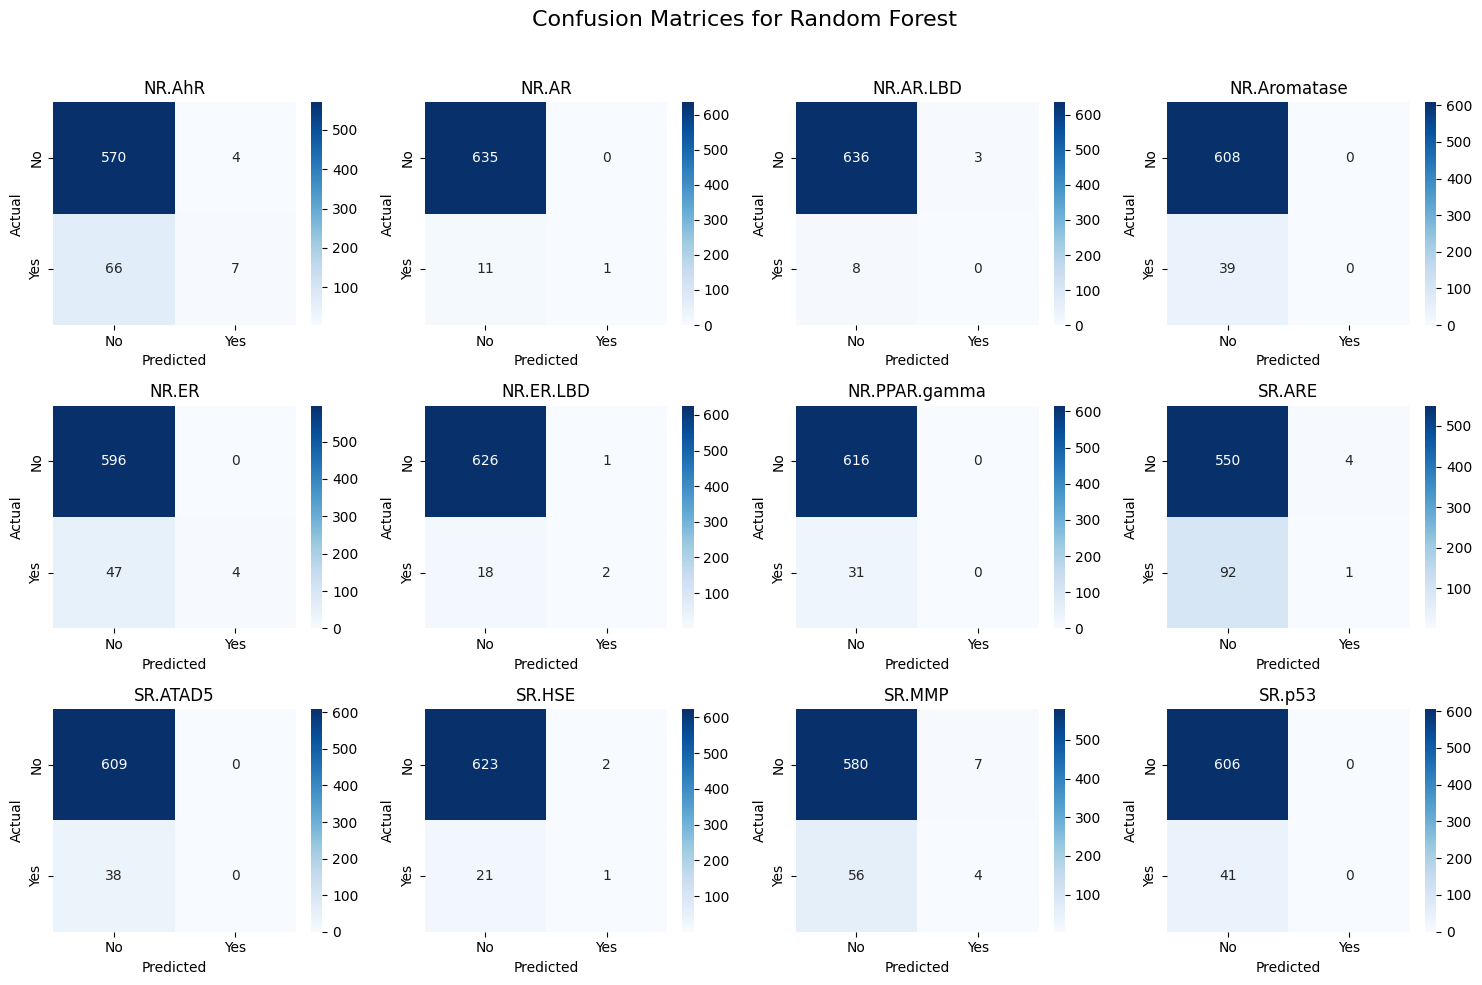

In [8]:
train_classifier("Random Forest", random_forest, X_train, y_train, X_test, y_test)


Training Gradient Boosting...
Gradient Boosting training completed.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:03:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



Accuracy for Gradient Boosting:
NR.AhR: Train Accuracy = 0.9915, Test Accuracy = 0.9011
NR.AR: Train Accuracy = 0.9959, Test Accuracy = 0.9845
NR.AR.LBD: Train Accuracy = 0.9978, Test Accuracy = 0.9861
NR.Aromatase: Train Accuracy = 0.9968, Test Accuracy = 0.9397
NR.ER: Train Accuracy = 0.9928, Test Accuracy = 0.9304
NR.ER.LBD: Train Accuracy = 0.9970, Test Accuracy = 0.9706
NR.PPAR.gamma: Train Accuracy = 0.9973, Test Accuracy = 0.9521
SR.ARE: Train Accuracy = 0.9893, Test Accuracy = 0.8516
SR.ATAD5: Train Accuracy = 0.9965, Test Accuracy = 0.9413
SR.HSE: Train Accuracy = 0.9956, Test Accuracy = 0.9645
SR.MMP: Train Accuracy = 0.9905, Test Accuracy = 0.9011
SR.p53: Train Accuracy = 0.9946, Test Accuracy = 0.9351


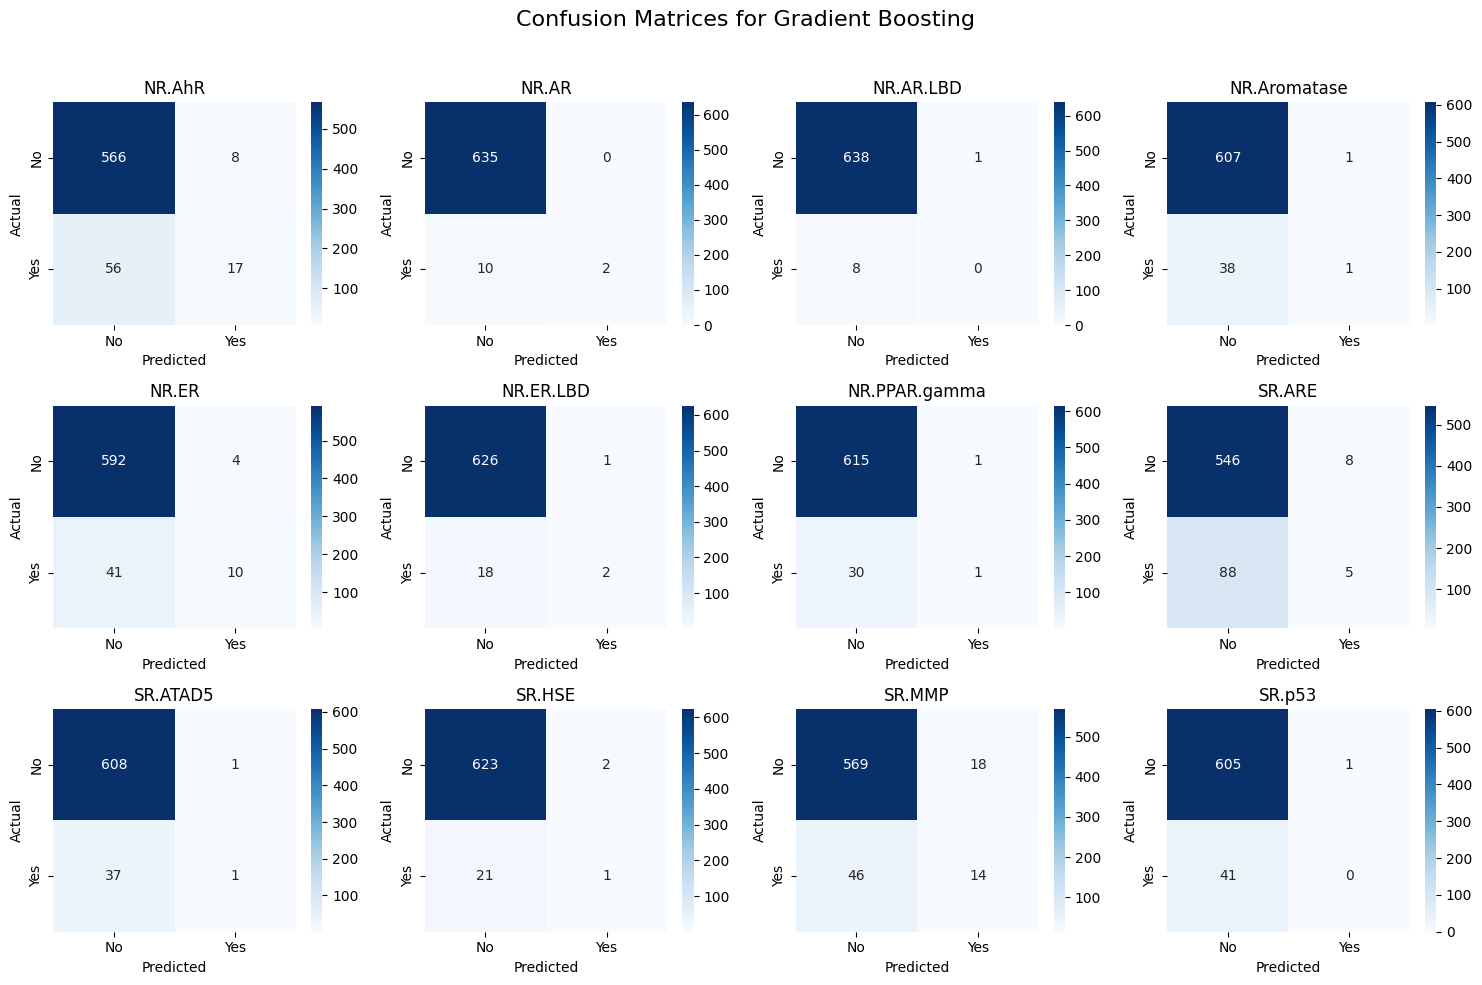

In [9]:
train_classifier("Gradient Boosting", gradient_boosting, X_train, y_train, X_test, y_test)


Training Naive Bayes...
Naive Bayes training completed.

Accuracy for Naive Bayes:
NR.AhR: Train Accuracy = 0.2303, Test Accuracy = 0.2303
NR.AR: Train Accuracy = 0.2628, Test Accuracy = 0.3076
NR.AR.LBD: Train Accuracy = 0.2410, Test Accuracy = 0.2365
NR.Aromatase: Train Accuracy = 0.3697, Test Accuracy = 0.4359
NR.ER: Train Accuracy = 0.1160, Test Accuracy = 0.1159
NR.ER.LBD: Train Accuracy = 0.1234, Test Accuracy = 0.1190
NR.PPAR.gamma: Train Accuracy = 0.0712, Test Accuracy = 0.0927
SR.ARE: Train Accuracy = 0.1290, Test Accuracy = 0.1731
SR.ATAD5: Train Accuracy = 0.1174, Test Accuracy = 0.1252
SR.HSE: Train Accuracy = 0.1053, Test Accuracy = 0.0896
SR.MMP: Train Accuracy = 0.2678, Test Accuracy = 0.3045
SR.p53: Train Accuracy = 0.5543, Test Accuracy = 0.5889


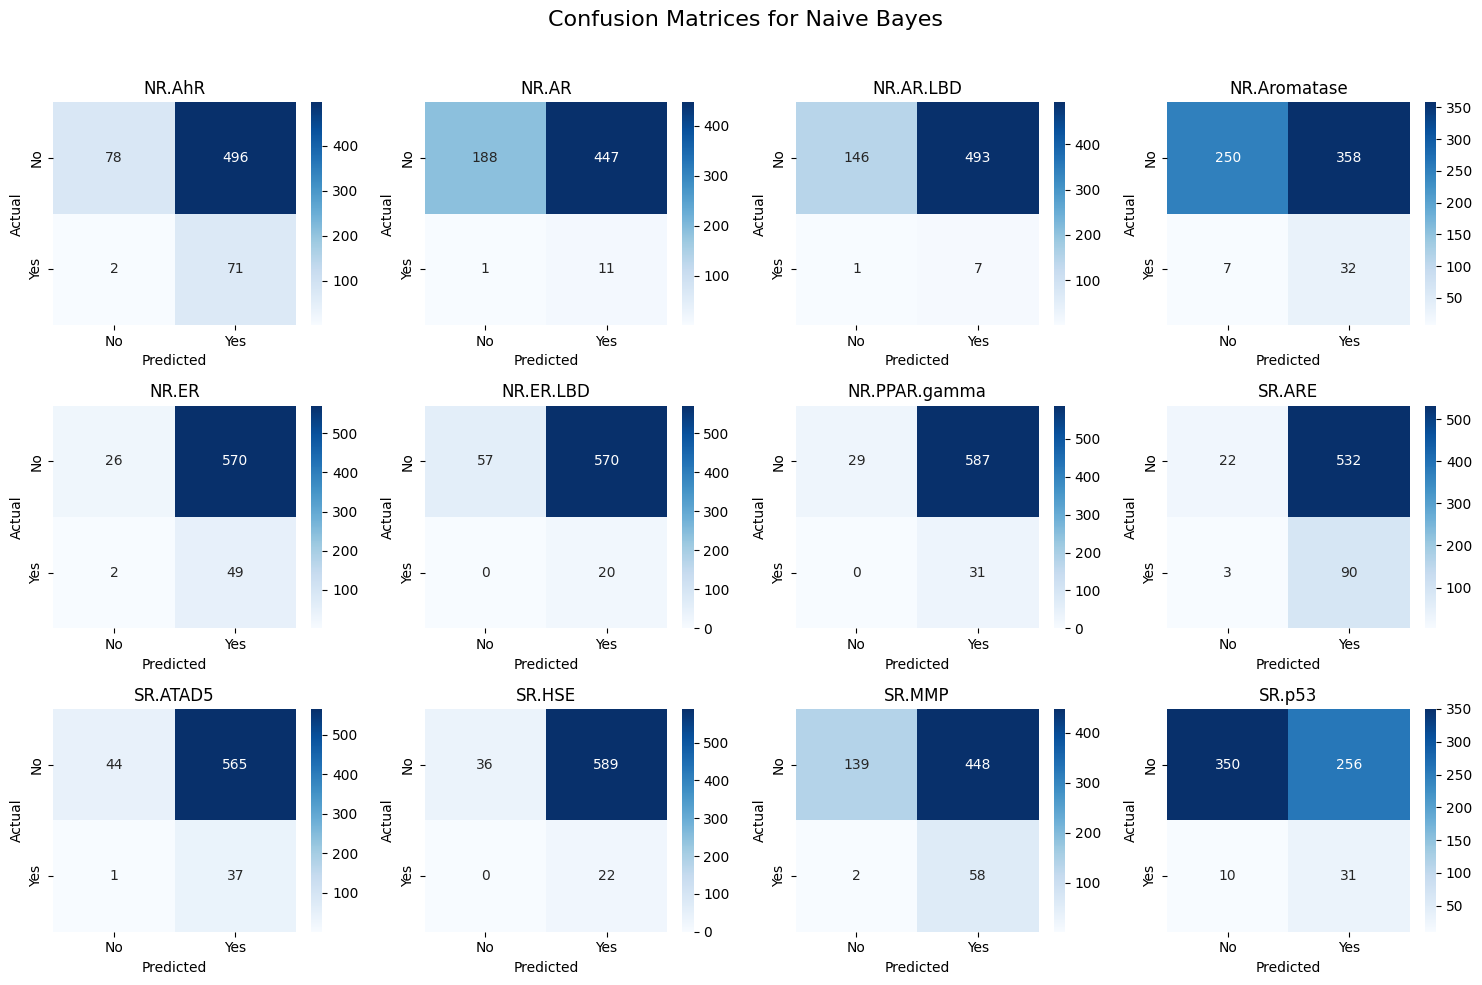

In [10]:
train_classifier("Naive Bayes", naive_bayes, X_train, y_train, X_test, y_test)


Training KNN...
[2025-03-30 12:03:39.842] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-03-30 12:03:40.020] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-03-30 12:03:40.121] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-03-30 12:03:40.199] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-03-30 12:03:40.238] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-03-30 12:03:40.275] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-03-30 12:03:40.312] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-03-30 12:03:40.352] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
[2025-03-30 12:03:40.389] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initiali

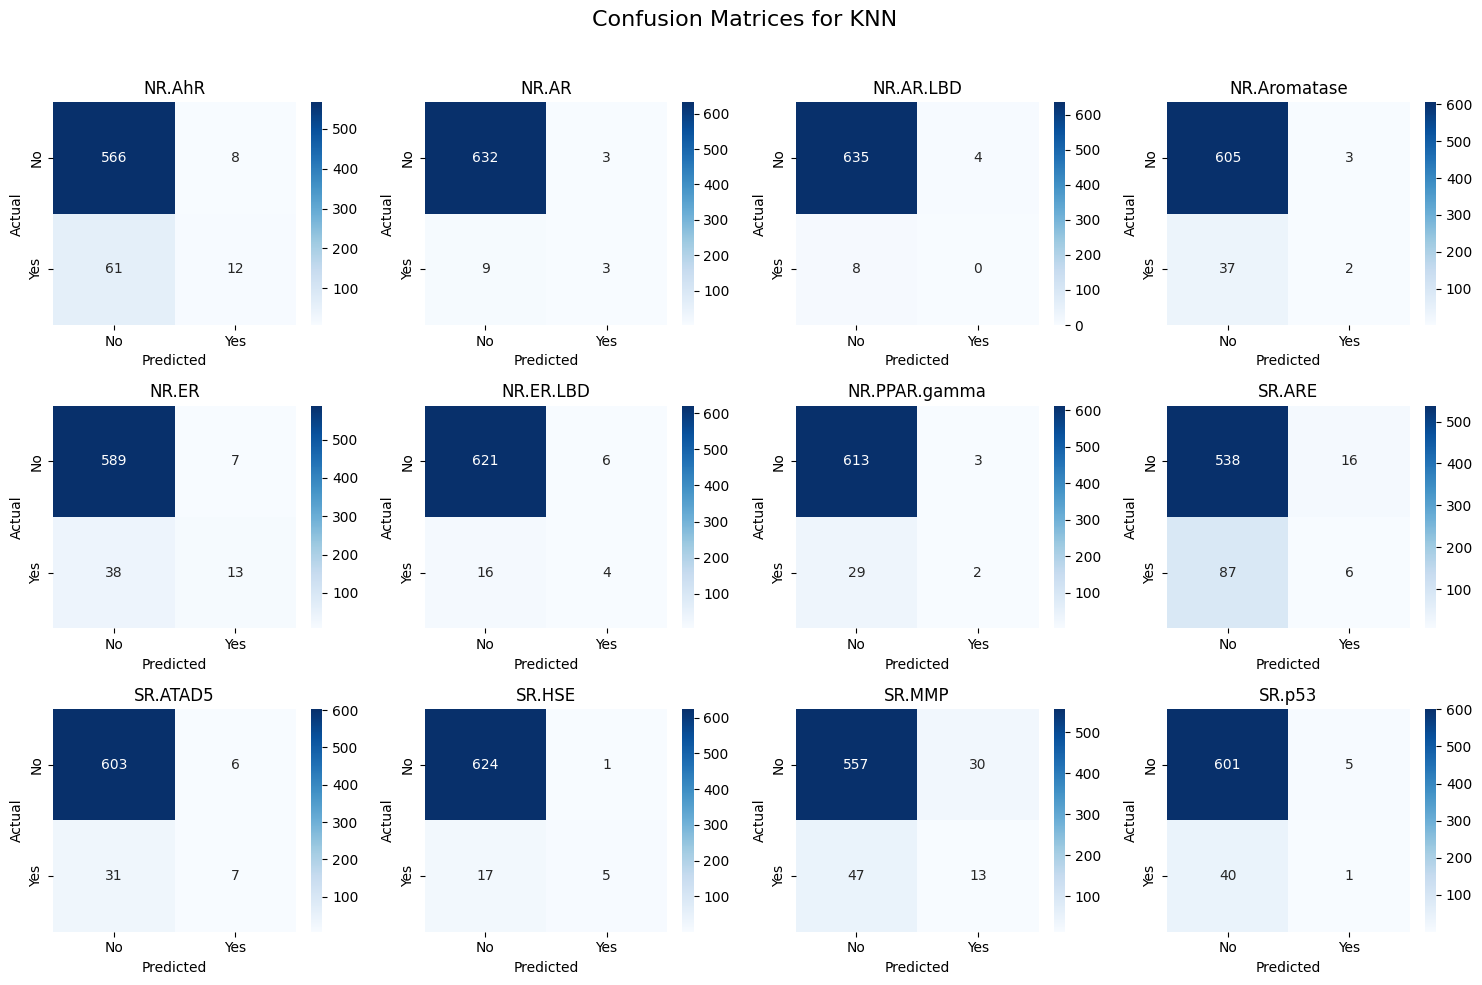

In [11]:
train_classifier("KNN", knn, X_train, y_train, X_test, y_test)


Training Decision Tree...
Decision Tree training completed.

Accuracy for Decision Tree:
NR.AhR: Train Accuracy = 0.9915, Test Accuracy = 0.8501
NR.AR: Train Accuracy = 0.9959, Test Accuracy = 0.9521
NR.AR.LBD: Train Accuracy = 0.9978, Test Accuracy = 0.9675
NR.Aromatase: Train Accuracy = 0.9968, Test Accuracy = 0.8964
NR.ER: Train Accuracy = 0.9932, Test Accuracy = 0.8563
NR.ER.LBD: Train Accuracy = 0.9970, Test Accuracy = 0.9243
NR.PPAR.gamma: Train Accuracy = 0.9973, Test Accuracy = 0.9335
SR.ARE: Train Accuracy = 0.9899, Test Accuracy = 0.7867
SR.ATAD5: Train Accuracy = 0.9965, Test Accuracy = 0.9181
SR.HSE: Train Accuracy = 0.9956, Test Accuracy = 0.9258
SR.MMP: Train Accuracy = 0.9905, Test Accuracy = 0.8563
SR.p53: Train Accuracy = 0.9946, Test Accuracy = 0.8918


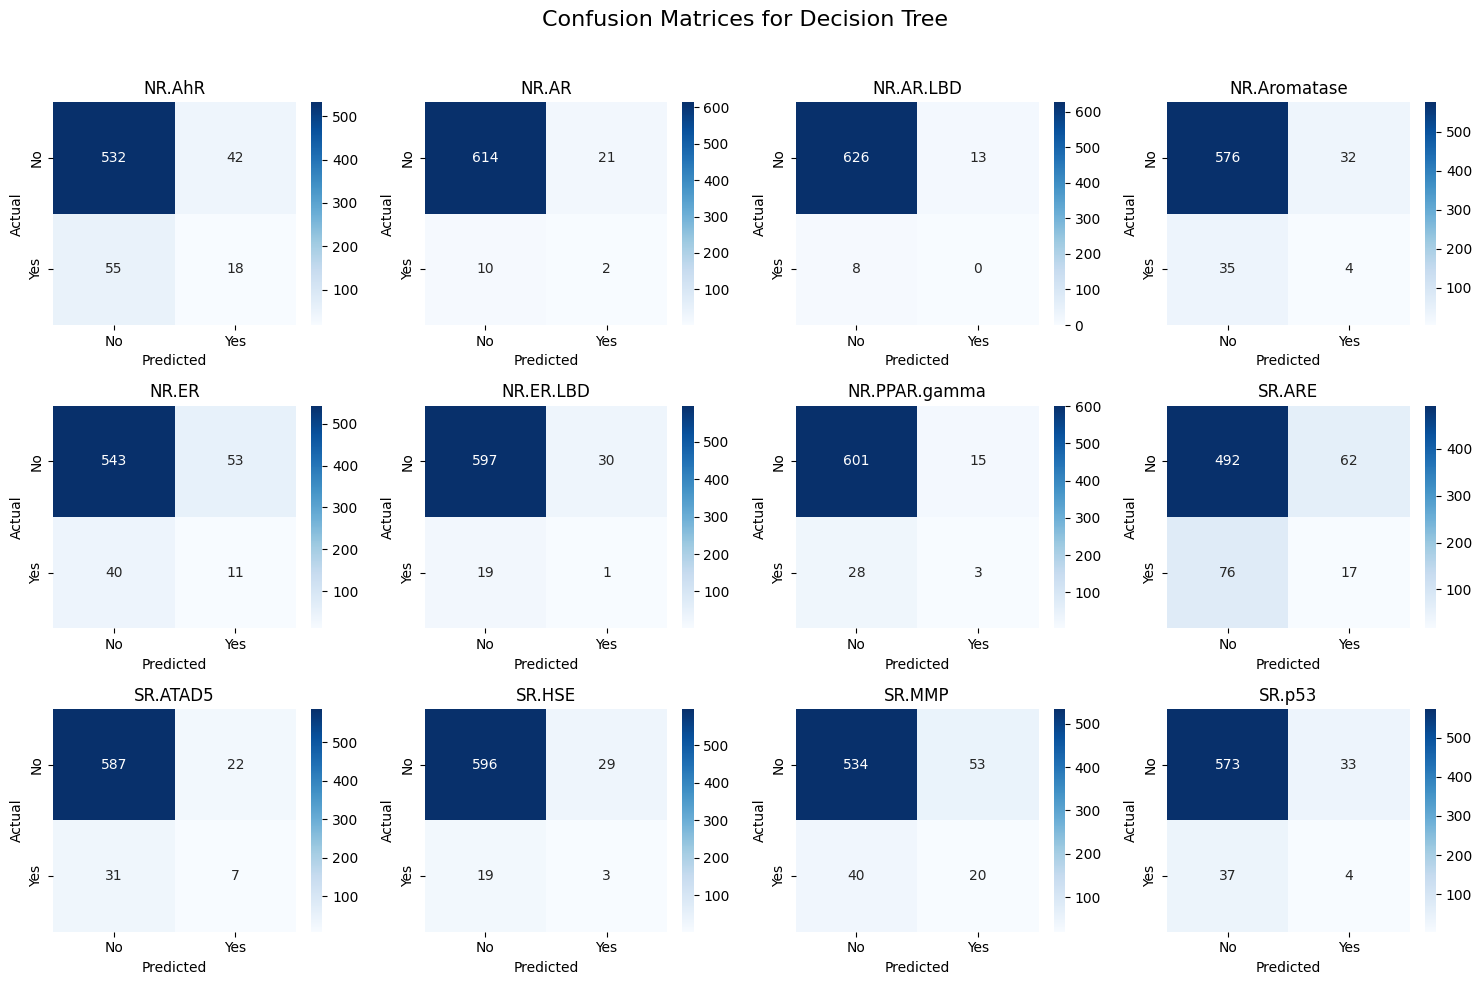

In [12]:
train_classifier("Decision Tree", decision_tree, X_train, y_train, X_test, y_test)



Training SVM...
SVM training completed.

Accuracy for SVM:
NR.AhR: Train Accuracy = 0.9368, Test Accuracy = 0.8949
NR.AR: Train Accuracy = 0.9785, Test Accuracy = 0.9722
NR.AR.LBD: Train Accuracy = 0.9870, Test Accuracy = 0.9706
NR.Aromatase: Train Accuracy = 0.9733, Test Accuracy = 0.9382
NR.ER: Train Accuracy = 0.9221, Test Accuracy = 0.9134
NR.ER.LBD: Train Accuracy = 0.9755, Test Accuracy = 0.9614
NR.PPAR.gamma: Train Accuracy = 0.9861, Test Accuracy = 0.9428
SR.ARE: Train Accuracy = 0.9075, Test Accuracy = 0.8485
SR.ATAD5: Train Accuracy = 0.9751, Test Accuracy = 0.9366
SR.HSE: Train Accuracy = 0.9699, Test Accuracy = 0.9675
SR.MMP: Train Accuracy = 0.9228, Test Accuracy = 0.8903
SR.p53: Train Accuracy = 0.9592, Test Accuracy = 0.9289


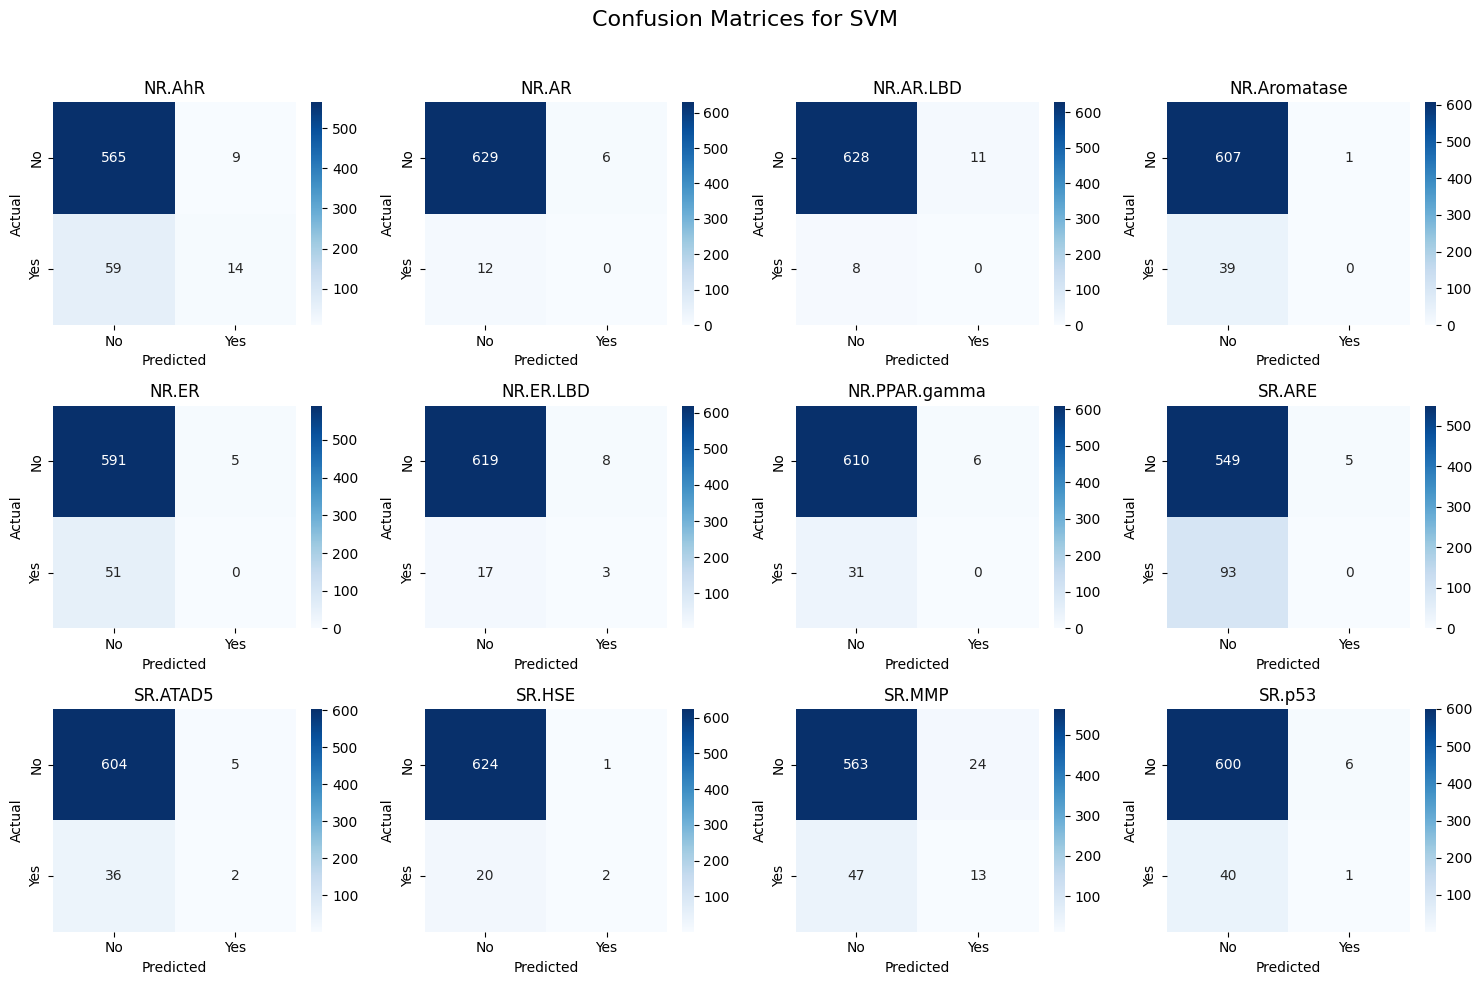

In [13]:
train_classifier("SVM", svm, X_train, y_train, X_test, y_test)